In [1]:
!pip install folium

     |████████████████████████████████| 92kB 13.9MB/s eta 0:00:01


In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_936868e3b7a041a29ed5e6d8d6527c8e = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='c75VEKJovc437dcCqrvx-o1BIBaBzO-f8dFNskMKpSDJ',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_936868e3b7a041a29ed5e6d8d6527c8e.get_object(Bucket='datascience-donotdelete-pr-dbwhvmvxvlzh9z',Key='listings_summary.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_listing_summ = pd.read_csv(body)

In [3]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
from scipy.stats import norm
import scipy
import matplotlib.pyplot as plt
import folium
%matplotlib inline
pd.set_option('display.max_columns', 500)
mpl.style.use(['seaborn-darkgrid'])

In [4]:
df_listing_summ.shape

(22552, 96)

In [5]:
#ignore unwanted columns like URLs
columns_to_keep = ['id','host_has_profile_pic','host_since',
                   'latitude', 'longitude','property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'price', 'cleaning_fee',
                   'security_deposit', 'minimum_nights',  
                   'instant_bookable', 'cancellation_policy','availability_365']
df_listing_summ = df_listing_summ[columns_to_keep].set_index('id')

In [6]:
df_listing_summ.shape

(22552, 18)

In [7]:
#Check null values in each column for further cleaning
df_listing_summ.isnull().sum()

host_has_profile_pic      26
host_since                26
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bathrooms                 32
bedrooms                  18
bed_type                   0
amenities                  0
price                      0
cleaning_fee            7146
security_deposit        9361
minimum_nights             0
instant_bookable           0
cancellation_policy        0
availability_365           0
dtype: int64

In [8]:
#Convert f,t to 0 or 1
df_listing_summ['instant_bookable'] = df_listing_summ['instant_bookable'].map({'f':0,'t':1})

In [9]:
#fill f for N/A in host_has_profile_pic column for further correct mapping
set(df_listing_summ['host_has_profile_pic'])
df_listing_summ['host_has_profile_pic'].fillna('f',inplace=True)

In [10]:
#Convert f,t to 0 or 1
df_listing_summ['host_has_profile_pic'] = df_listing_summ['host_has_profile_pic'].map({'f':0,'t':1})

In [11]:
#Remove $ from price, fee columns and convert to float
df_listing_summ['price'] = df_listing_summ['price'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['cleaning_fee'] = df_listing_summ['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype(float)
df_listing_summ['security_deposit'] = df_listing_summ['security_deposit'].str.replace('$', '').str.replace(',', '').astype(float)

In [12]:
#cleaning_fee cleanup of N/a replace with median value
df_listing_summ['cleaning_fee'].fillna(df_listing_summ['cleaning_fee'].median(), inplace=True)

In [13]:
#security_deposit cleanup of N/a replace with median value
df_listing_summ['security_deposit'].fillna(df_listing_summ['security_deposit'].median(), inplace=True)

In [14]:
#Check distribution of price column
df_listing_summ['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

### As we see above 75% of prices are near 70 Euros , but min is 0 & max is 9000. Lets drop anything above 200

In [15]:
df_listing_summ.drop(df_listing_summ[ (df_listing_summ.price > 200) | (df_listing_summ.price == 0) ].index, axis=0, inplace=True)
df_listing_summ['price'].describe()

count    22132.000000
mean        54.567188
std         33.198252
min          1.000000
25%         30.000000
50%         45.000000
75%         69.000000
max        200.000000
Name: price, dtype: float64

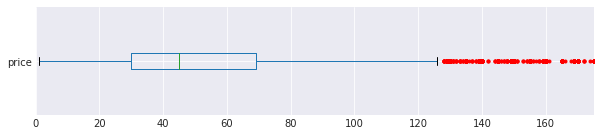

In [16]:
# boxplot of price column
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_listing_summ['price'].plot(kind='box', xlim=(0, 175), vert=False, flierprops=red_square, figsize=(10,2));

In [17]:
#cleanup bathroom , bedroom columns
df_listing_summ['bathrooms'].fillna(1,inplace=True)
df_listing_summ['bedrooms'].fillna(1,inplace=True)

# Display no. of rooms by type

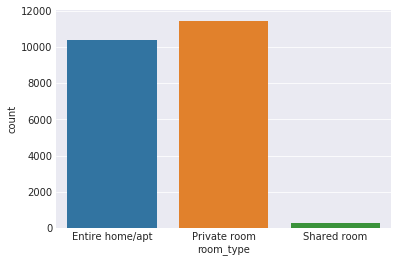

In [18]:
sns.countplot(x='room_type',data=df_listing_summ)

### This indicates most no. of listings rent entire home/apt. or private rooms

In [19]:
df_listing_summ['cancellation_policy'].value_counts()

flexible                       8985
moderate                       6993
strict_14_with_grace_period    6099
super_strict_30                  47
super_strict_60                   8
Name: cancellation_policy, dtype: int64

### This means most no. of listings have a flexible cancellation policy

### Create new columns for amenties

In [20]:
df_listing_summ['No_of_amentities'] = df_listing_summ['amenities'].apply(lambda x:len(x.split(',')))

In [21]:
df_listing_summ['Laptop_friendly_workspace'] = df_listing_summ['amenities'].str.contains('Laptop friendly workspace')
df_listing_summ['TV'] = df_listing_summ['amenities'].str.contains('TV')
df_listing_summ['Family_kid_friendly'] = df_listing_summ['amenities'].str.contains('Family/kid friendly')
df_listing_summ['Host_greets_you'] = df_listing_summ['amenities'].str.contains('Host greets you')
df_listing_summ['Smoking_allowed'] = df_listing_summ['amenities'].str.contains('Smoking allowed')
df_listing_summ['Hot_water'] = df_listing_summ['amenities'].str.contains('Hot water')
df_listing_summ['Fridge'] = df_listing_summ['amenities'].str.contains('Refrigerator')

In [22]:
#dropping amenities as we have inferred above as different categories
dropped = ['amenities']
df_listing_summ.drop(dropped,axis=1,inplace=True)

In [23]:
df_listing_summ.head()

,host_has_profile_pic,host_since,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,price,cleaning_fee,security_deposit,minimum_nights,instant_bookable,cancellation_policy,availability_365,No_of_amentities,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge
id,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1,2008-08-18,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,60.0,30.0,200.0,4,0,strict_14_with_grace_period,141,29,True,True,True,False,False,True,True
2695,1,2008-09-16,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,17.0,0.0,0.0,2,0,flexible,0,10,True,False,False,False,False,False,False
3176,1,2008-10-19,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,90.0,50.0,200.0,62,1,strict_14_with_grace_period,220,19,True,False,True,False,False,False,False
3309,1,2008-11-07,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,26.0,30.0,250.0,5,0,strict_14_with_grace_period,297,29,True,False,False,True,False,True,False
7071,1,2009-05-16,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,42.0,0.0,0.0,2,0,moderate,26,13,True,False,True,False,False,True,False


In [24]:
#Convert false,true to 0 or 1
df_listing_summ['Laptop_friendly_workspace'] = df_listing_summ['Laptop_friendly_workspace'].astype(int)
df_listing_summ['TV'] = df_listing_summ['TV'].astype(int)
df_listing_summ['Family_kid_friendly'] = df_listing_summ['Family_kid_friendly'].astype(int)
df_listing_summ['Host_greets_you'] = df_listing_summ['Host_greets_you'].astype(int)
df_listing_summ['Smoking_allowed'] = df_listing_summ['Smoking_allowed'].astype(int)
df_listing_summ['Hot_water'] = df_listing_summ['Hot_water'].astype(int)
df_listing_summ['Fridge'] = df_listing_summ['Fridge'].astype(int)

In [25]:
df_listing_summ.head()

,host_has_profile_pic,host_since,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,price,cleaning_fee,security_deposit,minimum_nights,instant_bookable,cancellation_policy,availability_365,No_of_amentities,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge
id,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1,2008-08-18,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,60.0,30.0,200.0,4,0,strict_14_with_grace_period,141,29,1,1,1,0,0,1,1
2695,1,2008-09-16,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,17.0,0.0,0.0,2,0,flexible,0,10,1,0,0,0,0,0,0
3176,1,2008-10-19,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,90.0,50.0,200.0,62,1,strict_14_with_grace_period,220,19,1,0,1,0,0,0,0
3309,1,2008-11-07,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,26.0,30.0,250.0,5,0,strict_14_with_grace_period,297,29,1,0,0,1,0,1,0
7071,1,2009-05-16,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,42.0,0.0,0.0,2,0,moderate,26,13,1,0,1,0,0,1,0


### calculate distances from central berlin to check later if it influences price

In [26]:
from math import sin, cos, sqrt, atan2, radians

In [27]:
#Calculate distance from central berlin
def haversine_distance_central(row):
    berlin_lat,berlin_long = radians(52.5200), radians(13.4050)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [28]:
#Calculate distance from airport
def haversine_distance_airport(row):
    berlin_lat,berlin_long = radians(52.3733), radians(13.5064)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [29]:
#Calculate distance from berlin railway station
def haversine_distance_rail(row):
    berlin_lat,berlin_long = radians(52.5073), radians(13.3324)
    R = 6373.0
    long = radians(row['longitude'])
    lat = radians(row['latitude'])
    
    dlon = long - berlin_long
    dlat = lat - berlin_lat
    a = sin(dlat / 2)**2 + cos(lat) * cos(berlin_lat) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [30]:
df_listing_summ['distance_central'] = df_listing_summ.apply(haversine_distance_central,axis=1)
df_listing_summ['distance_airport'] = df_listing_summ.apply(haversine_distance_airport,axis=1)
df_listing_summ['distance_railways'] = df_listing_summ.apply(haversine_distance_rail,axis=1)
df_listing_summ['distance_avg'] = ( df_listing_summ['distance_central'] + df_listing_summ['distance_airport'] + df_listing_summ['distance_railways'] )/3.0

In [31]:
df_listing_summ['distance_avg'].describe()

count    22132.000000
mean         9.408715
std          1.786757
min          7.499669
25%          8.289105
50%          9.007905
75%          9.964415
max         24.636447
Name: distance_avg, dtype: float64

In [32]:
df_listing_summ.head()

,host_has_profile_pic,host_since,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,bed_type,price,cleaning_fee,security_deposit,minimum_nights,instant_bookable,cancellation_policy,availability_365,No_of_amentities,Laptop_friendly_workspace,TV,Family_kid_friendly,Host_greets_you,Smoking_allowed,Hot_water,Fridge,distance_central,distance_airport,distance_railways,distance_avg
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015,1,2008-08-18,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,Real Bed,60.0,30.0,200.0,4,0,strict_14_with_grace_period,141,29,1,1,1,0,0,1,1,1.625414,19.266232,5.632427,8.841357
2695,1,2008-09-16,52.548513,13.404553,Apartment,Private room,2,1.0,1.0,Real Bed,17.0,0.0,0.0,2,0,flexible,0,10,1,0,0,0,0,0,0,3.171617,20.675116,6.697246,10.181326
3176,1,2008-10-19,52.534996,13.417579,Apartment,Entire home/apt,4,1.0,1.0,Real Bed,90.0,50.0,200.0,62,1,strict_14_with_grace_period,220,19,1,0,1,0,0,0,0,1.872657,18.966373,6.536374,9.125135
3309,1,2008-11-07,52.498855,13.349065,Apartment,Private room,2,1.0,1.0,Pull-out Sofa,26.0,30.0,250.0,5,0,strict_14_with_grace_period,297,29,1,0,0,1,0,1,0,4.457682,17.574477,1.468150,7.833436
7071,1,2009-05-16,52.543157,13.415091,Apartment,Private room,2,1.0,1.0,Real Bed,42.0,0.0,0.0,2,0,moderate,26,13,1,0,1,0,0,1,0,2.664743,19.880937,6.871866,9.805849


In [33]:
df_listing_summ.sort_values(by='price',ascending=False,axis=0,inplace=True) #sorting frame by price desc

In [34]:
df_list_summ_top10000 = df_listing_summ.head(10000)
df_list_summ_top1000 = df_listing_summ.head(1000)

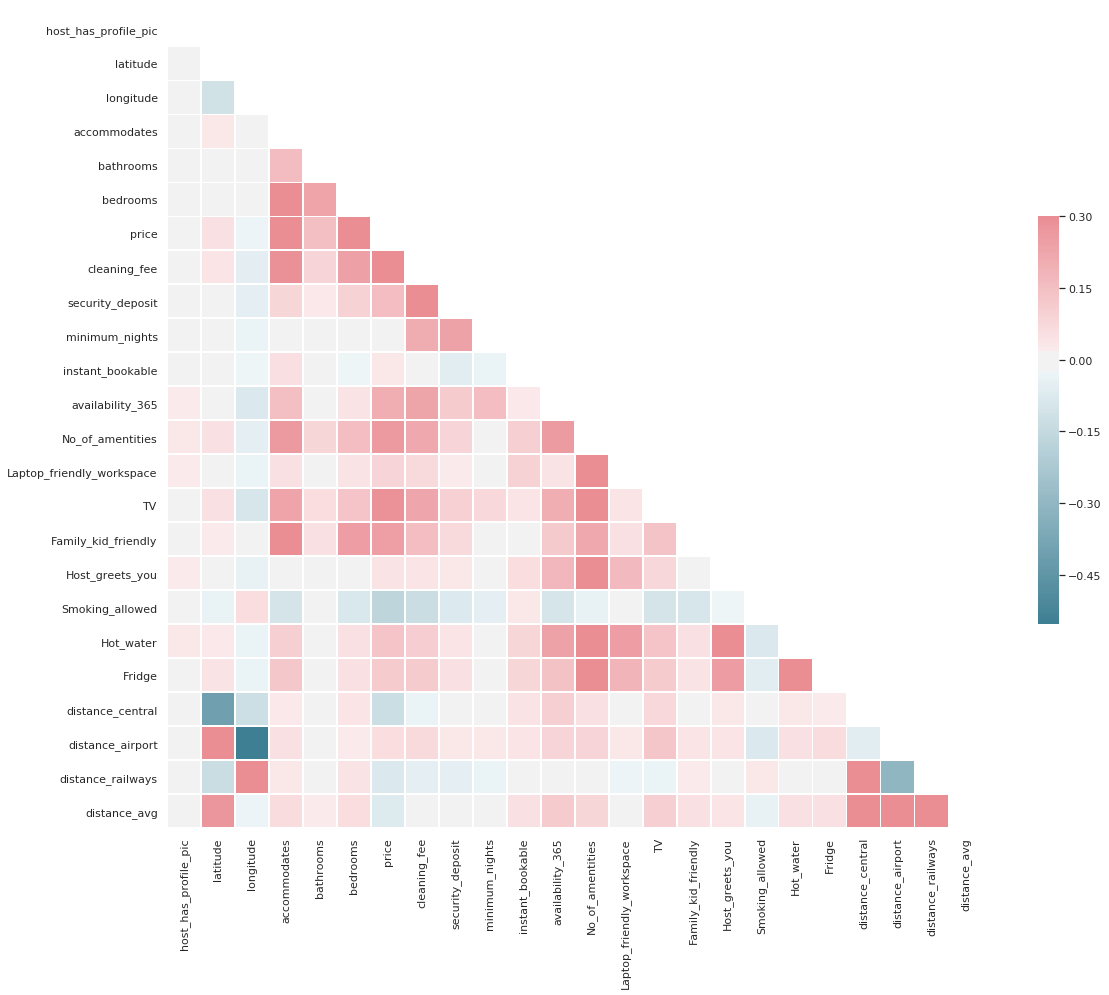

In [35]:
sns.set(style="white")
corr = df_listing_summ.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 15))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink":.5},cbar=True);

## Price seems to depend largely on following factors
* No. of ameneties
* Is it family or kids friendly
* Cleaning fee
* Capacity i.e how many guests it can accomodate

Lets gets p-values & pearson's coefficients for price w.r.t. some columns

* p-value is < 0.001: we say there is strong evidence that the correlation is significant. 
* the p-value is < 0.05: there is moderate evidence that the correlation is significant. 
* the p-value is < 0.1: there is weak evidence that the correlation is significant. 
* the p-value is > 0.1: there is no evidence that the correlation is significant.

In [36]:
from scipy import stats
pearson_coef, p_value = stats.pearsonr(df_listing_summ['accommodates'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)  

The Pearson Correlation Coefficient is 0.5361129972955838  with a P-value of P = 0.0


In [37]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['cleaning_fee'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.38087552375274336  with a P-value of P = 0.0


In [38]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['security_deposit'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.1592453129486869  with a P-value of P = 1.2377472463014333e-125


In [39]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['distance_avg'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is -0.06999910431444747  with a P-value of P = 1.889668913174063e-25


In [40]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['Family_kid_friendly'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.24806336588064104  with a P-value of P = 1.3753763048581066e-307


In [41]:
pearson_coef, p_value = stats.pearsonr(df_listing_summ['No_of_amentities'], df_listing_summ['price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value) 

The Pearson Correlation Coefficient is 0.26631903277747404  with a P-value of P = 0.0


In [549]:
lat = 52.509
long = 13.381
base = folium.Map(location=[lat,long], zoom_start=12) #base map setting
base

In [550]:
neighbourhoods = folium.map.FeatureGroup()

In [551]:
lat_long_list = [[52.520,13.405],[52.373,13.506],[52.507,13.332]] #locatioms of central berlin , railway stn, airport

In [552]:
for i in range(0,len(lat_long_list)):
    neighbourhoods.add_child(
        folium.CircleMarker(
        lat_long_list[i],
        radius = 16,
        color='yellow',
        fill=True,
        fill_color='red',
        fill_opacity=0.6
        )
    )
base.add_child(neighbourhoods)

In [553]:
neighbourhoods = folium.map.FeatureGroup()
for inc_lat,inc_long in zip(df_list_summ_top1000.longitude,df_list_summ_top1000.latitude):
    neighbourhoods.add_child(
    folium.CircleMarker(
    [inc_long,inc_lat],
    radius = 5,
    color='yellow',
    fill=True,
    fill_color='blue',
    fill_opacity=0.6
    )
)
base.add_child(neighbourhoods)

### This means top 1000 properties are around central berlin & railway station and very few near airport
### This is also evident from below dist plots where properties are mostly around central berlin & railway station

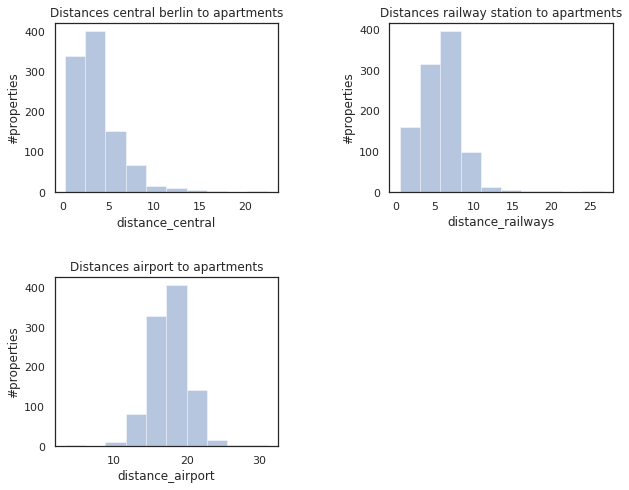

In [554]:
fig = plt.figure(figsize=(10,6))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)

sns.distplot(df_list_summ_top1000["distance_central"], bins=10, kde=False,ax=ax0)
ax0.set_title('Distances central berlin to apartments')
ax0.set_xlabel('distance_central')
ax0.set_ylabel('#properties')

sns.distplot(df_list_summ_top1000["distance_railways"], bins=10, kde=False,ax=ax1)
ax1.set_title('Distances railway station to apartments')
ax1.set_xlabel('distance_railways')
ax1.set_ylabel('#properties')

sns.distplot(df_list_summ_top1000["distance_airport"], bins=10, kde=False,ax=ax2)
ax2.set_title('Distances airport to apartments')
ax2.set_xlabel('distance_airport')
ax2.set_ylabel('#properties')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.5)
plt.show()

In [555]:
body = client_936868e3b7a041a29ed5e6d8d6527c8e.get_object(Bucket='datascience-donotdelete-pr-dbwhvmvxvlzh9z',Key='reviews_summary.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_rsumm = pd.read_csv(body)

In [556]:
import datetime
def mapper(month):
    date = datetime.datetime(2000, month, 1)  # You need a dateobject with the proper month
    return date.strftime('%b')  # %b returns the months abbreviation, other options [here][1]

In [557]:
df_rsumm['date'] = pd.to_datetime(df_rsumm['date'])
df_rsumm['year'] = df_rsumm['date'].dt.year
df_rsumm['month'] = df_rsumm['date'].dt.month
df_rsumm['day'] = df_rsumm['date'].dt.day

df_rsumm['year'] = df_rsumm['year'].astype(int)
df_rsumm['month'] = df_rsumm['month'].astype(int)
df_rsumm['day'] = df_rsumm['day'].astype(int)

In [558]:
df_rsumm.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,day
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...,2016,4,11
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,2016,4,15
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...,2016,4,26
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ...",2016,5,10
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden...",2016,5,14


In [559]:
df_rsumm.sort_values(['year', 'month'], ascending=[True, True],axis=0,inplace=True) #sorting frame by year,month asc

In [560]:
df_rsumm['month'] = df_rsumm['month'].apply(mapper) ##convert month to month name

In [561]:
df_rsumm_orig = df_rsumm.copy(deep=False) #shallow copy

In [562]:
df_rsumm_orig.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month,day
124,3176,4283,2009-06-20,21475,Milan,"excellent stay, i would highly recommend it. a...",2009,Jun,20
292,7071,7726,2009-08-18,30084,Ben,I could not have asked for a better place to s...,2009,Aug,18
293,7071,18259,2009-11-25,50988,Tarnia,"This room is really lovely! It is quiet, comf...",2009,Nov,25
845,17904,26752,2010-02-18,73252,Thomas,"It was a very calm, cute and warm studio, clos...",2010,Feb,18
294,7071,38158,2010-04-26,96258,Maria Cristina,Staying at bright room was realy nice and conf...,2010,Apr,26


In [563]:
dropped = ['reviewer_name','comments']
df_rsumm.drop(dropped,axis=1,inplace=True)

In [564]:
df_rsumm['year'].value_counts()

2018    152448
2017    111799
2016     69303
2015     39470
2014     17702
2013      7422
2012      3092
2011       617
2010       107
2009         3
Name: year, dtype: int64

In [565]:
df_2015 = df_rsumm[df_rsumm['year'] == 2015]
df_2016 = df_rsumm[df_rsumm['year'] == 2016]
df_2017 = df_rsumm[df_rsumm['year'] == 2017]
df_2018 = df_rsumm[df_rsumm['year'] == 2018]

In [566]:
#df_2014['yearmonth'] = df_2014['month'].astype(str)+"-"+df_2014['year'].astype(str)
#df_2015['yearmonth'] = df_2015['month'].astype(str)+"-"+df_2015['year'].astype(str)
#df_2016['yearmonth'] = df_2016['month'].astype(str)+"-"+df_2016['year'].astype(str)
#df_2017['yearmonth'] = df_2017['month'].astype(str)+"-"+df_2017['year'].astype(str)
#df_2018['yearmonth'] = df_2018['month'].astype(str)+"-"+df_2018['year'].astype(str)

In [567]:
dropped = ['year','day','id','date','listing_id']
df_2015.drop(dropped,axis=1,inplace=True)
df_2016.drop(dropped,axis=1,inplace=True)
df_2017.drop(dropped,axis=1,inplace=True)
df_2018.drop(dropped,axis=1,inplace=True)

In [568]:
df_2015["count"] = df_2015.groupby("month")["reviewer_id"].transform('count')
df_2016["count"] = df_2016.groupby("month")["reviewer_id"].transform('count')
df_2017["count"] = df_2017.groupby("month")["reviewer_id"].transform('count')
df_2018["count"] = df_2018.groupby("month")["reviewer_id"].transform('count')

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [569]:
dropped = ['reviewer_id']
df_2015.drop(dropped,axis=1,inplace=True)
df_2016.drop(dropped,axis=1,inplace=True)
df_2017.drop(dropped,axis=1,inplace=True)
df_2018.drop(dropped,axis=1,inplace=True)

In [570]:
df_2015 = df_2015.drop_duplicates()
df_2016 = df_2016.drop_duplicates()
df_2017 = df_2017.drop_duplicates()
df_2018 = df_2018.drop_duplicates()
df_2015=df_2015.reset_index(drop=True)
df_2016=df_2016.reset_index(drop=True)
df_2017=df_2017.reset_index(drop=True)
df_2018=df_2018.reset_index(drop=True)

In [571]:
df_2018.head()

,month,count
0,Jan,8780
1,Feb,8723
2,Mar,11008
3,Apr,13090
4,May,15654


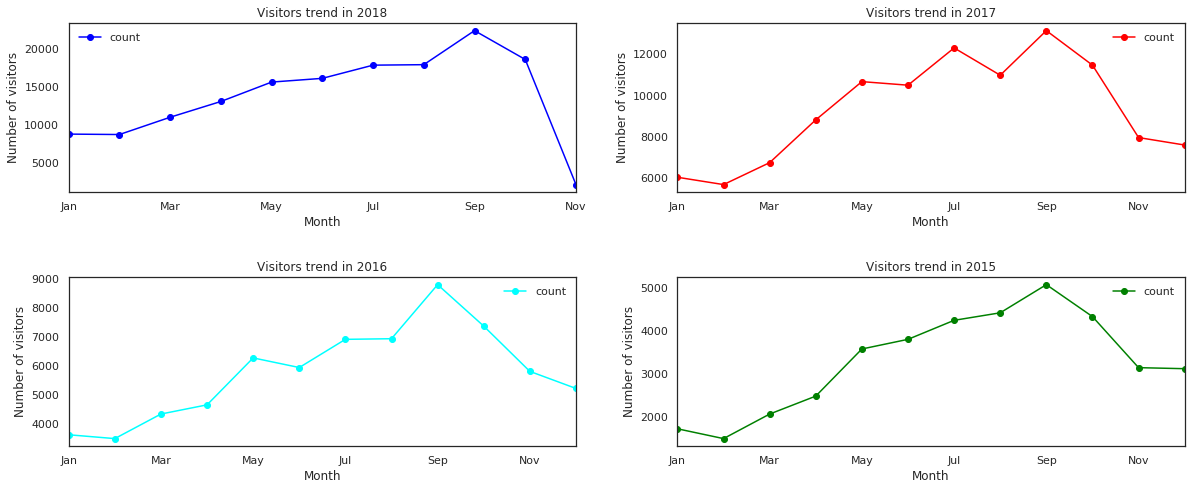

In [572]:
fig = plt.figure(figsize=(20, 6))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)

df_2018.plot(kind='line', color='blue', x='month',y='count',marker='o',ax=ax0) # add to subplot 1
ax0.set_title('Visitors trend in 2018')
ax0.set_xlabel('Month')
ax0.set_ylabel('Number of visitors')

df_2017.plot(kind='line', color='red', x='month',y='count',marker='o',ax=ax1) # add to subplot 2
ax1.set_title('Visitors trend in 2017')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of visitors')

df_2016.plot(kind='line', color='cyan', x='month',y='count',marker='o',ax=ax2) # add to subplot 3
ax2.set_title('Visitors trend in 2016')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of visitors')

df_2015.plot(kind='line', color='green', x='month',y='count',marker='o',ax=ax3) # add to subplot 4
ax3.set_title('Visitors trend in 2015')
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of visitors')

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5)
plt.show()

### Above plots indicate visitors peak during Sep each year

In [573]:
!pip install wordcloud

In [574]:
dropped = ['listing_id','id','reviewer_id','reviewer_name','day','date']
df_rsumm_orig.drop(dropped,axis=1,inplace=True)

In [575]:
df_rsumm_orig.head()

,comments,year,month
124,"excellent stay, i would highly recommend it. a...",2009,Jun
292,I could not have asked for a better place to s...,2009,Aug
293,"This room is really lovely! It is quiet, comf...",2009,Nov
845,"It was a very calm, cute and warm studio, clos...",2010,Feb
294,Staying at bright room was realy nice and conf...,2010,Apr


In [576]:
df_2015_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2015]
df_2016_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2016]
df_2017_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2017]
df_2018_comments = df_rsumm_orig[df_rsumm_orig['year'] == 2018]

In [577]:
df_2015_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2015) & (df_rsumm_orig['month'].str.contains("Sep"))]
df_2016_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2016) & (df_rsumm_orig['month'].str.contains("Sep"))]
df_2017_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2017) & (df_rsumm_orig['month'].str.contains("Sep"))]
df_2018_sep_comments = df_rsumm_orig[(df_rsumm_orig['year'] == 2018) & (df_rsumm_orig['month'].str.contains("Sep"))]

In [578]:
df_2015_sep_comments.head()

,comments,year,month
232,We love Prenzlauer Berg and staying in Britta'...,2015,Sep
233,"Britta’s apartment is perfect! clean, bright, ...",2015,Sep
373,"The bedroom is very nice, lightly and calm.\r\...",2015,Sep
374,Es hat alles super funktioniert und Can war se...,2015,Sep
375,Lovely room in a fabulous location in Prenzlau...,2015,Sep


In [579]:
dropped = ['month']
df_2015_comments.drop(dropped,axis=1,inplace=True)
df_2016_comments.drop(dropped,axis=1,inplace=True)
df_2017_comments.drop(dropped,axis=1,inplace=True)
df_2018_comments.drop(dropped,axis=1,inplace=True)
df_2015_comments=df_2015_comments.reset_index(drop=True)
df_2016_comments=df_2016_comments.reset_index(drop=True)
df_2017_comments=df_2017_comments.reset_index(drop=True)
df_2018_comments=df_2018_comments.reset_index(drop=True)

df_2015_sep_comments.drop(dropped,axis=1,inplace=True)
df_2016_sep_comments.drop(dropped,axis=1,inplace=True)
df_2017_sep_comments.drop(dropped,axis=1,inplace=True)
df_2018_sep_comments.drop(dropped,axis=1,inplace=True)
df_2015_sep_comments=df_2015_sep_comments.reset_index(drop=True)
df_2016_sep_comments=df_2016_sep_comments.reset_index(drop=True)
df_2017_sep_comments=df_2017_sep_comments.reset_index(drop=True)
df_2018_sep_comments=df_2018_sep_comments.reset_index(drop=True)

In [580]:
df_list_year_wise = [df_2015_comments,df_2016_comments,df_2017_comments,df_2018_comments] #list of all frames

In [581]:
df_list_sep = [df_2015_sep_comments,df_2016_sep_comments,df_2017_sep_comments,df_2018_sep_comments] #list of all frames

In [582]:
from wordcloud import WordCloud,STOPWORDS

In [583]:
stopwords = set(STOPWORDS)

In [584]:
rev_comments_wc = WordCloud(
    background_color='white',
    max_words=100000, #if we dont give this it does for entire rows for that frame
    stopwords = stopwords
)
#instantinate word cloud objects
def show_wclouds(text):
    rev_comments_wc.generate(text)
    return(rev_comments_wc)

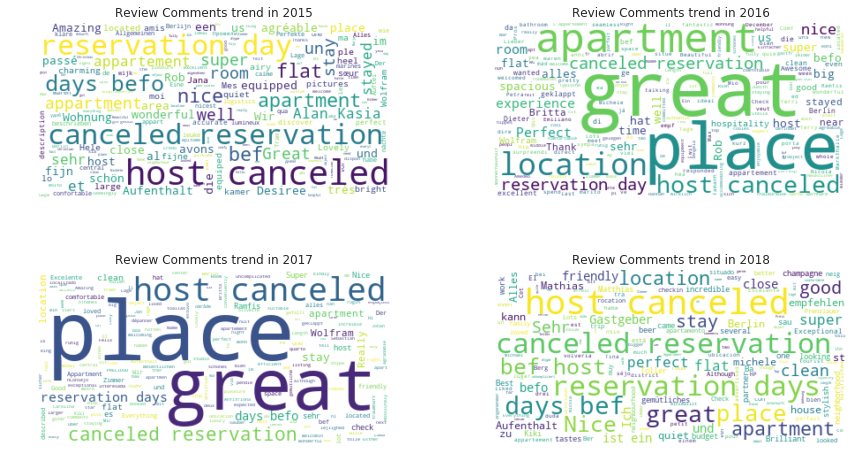

In [585]:
fig = plt.figure(figsize=(15, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
for i in range(0,len(df_list_year_wise)):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(show_wclouds(str(df_list_year_wise[i]['comments'])),interpolation='bilinear')
    ax.axis('off')
    title="Review Comments trend in "+str(df_list_year_wise[i]['year'].head(1).values[0])
    ax.set_title(title)

### Above indicates in 2016,2017 there were lot of visitors gave good review comments on properties but in 2015,2018 there were lot of cancellations as well

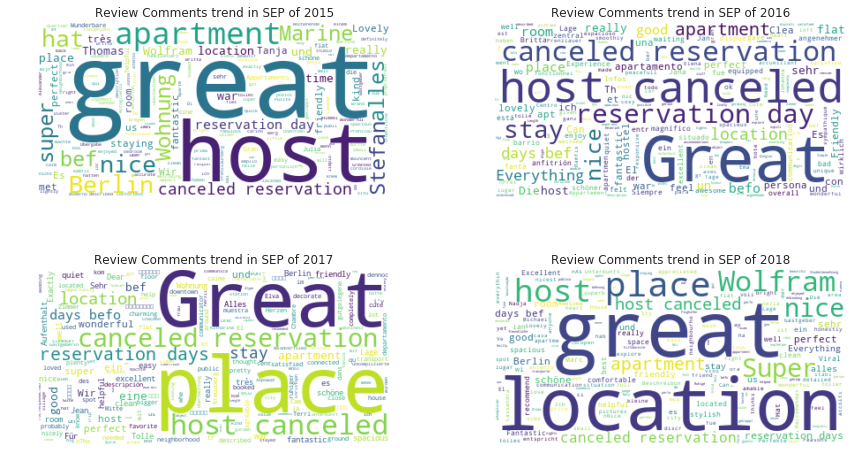

In [587]:
fig = plt.figure(figsize=(15, 6))
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4)
for i in range(0,len(df_list_sep)):
    ax = fig.add_subplot(2,2,i+1)
    ax.imshow(show_wclouds(str(df_list_sep[i]['comments'])),interpolation='bilinear')
    ax.axis('off')
    title="Review Comments trend in SEP of "+str(df_list_sep[i]['year'].head(1).values[0])
    ax.set_title(title)

### Above indicates in SEP of each year (where we have most visitors), most people gave good reviews